In [120]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import warnings

from tqdm.notebook import tqdm
from sklearn.metrics import r2_score
from scipy import stats
from scipy.optimize import minimize_scalar

from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.discrete.discrete_model import NegativeBinomial
from statsmodels.tools.sm_exceptions import ConvergenceWarning, HessianInversionWarning
sns.set_context("paper", font_scale=1.6)


In [121]:
# In the bootstrapping procedures some iteration do not converge well, we filter the messages to avoid clutter
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', HessianInversionWarning)

# Loading data

Load the meta-analysis annotations into a Pandas DataFrame

In [3]:
# Load causal and explainability papers
causal = pd.read_excel('meta_analysis_data/Annotations_XAI_Biomedical.xlsx', sheet_name='Causal')
exp = pd.read_excel('meta_analysis_data/Annotations_XAI_Biomedical.xlsx', sheet_name='Explainability')

# Merge the two categories in a shared DataFrame
category = causal['paper category'].tolist() + exp['paper category'].tolist() 
dates = causal['date'].tolist() + exp['date'].tolist()
covid = causal['role of covid'].tolist() + exp['role of COVID'].tolist()
df = pd.DataFrame({'category': category, 'covid': covid, 'date': dates})# , "type":paper_type})
print('There are %d annotations in total' %df.shape[0])

# Remove duplicate entries, unrelated papers and works not in English
df = df.dropna()
df = df[(df['category'] != 'not in English') & (df['category'] != 'other error')]

# Format date as datetime object
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")
df = df.sort_values(by="date").reset_index(drop=True)
df

There are 1603 annotations in total


/home/gvisona/miniconda3/envs/series/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


,category,covid,date
0,evaluation or application of XAI methods,Covid is not mentioned in the title or abstract,2010-03-02
1,evaluation or application of XAI methods,Covid is not mentioned in the title or abstract,2010-05-14
2,evaluation or application of XAI methods,Covid is not mentioned in the title or abstract,2010-06-11
3,evaluation or application of XAI methods,Covid is not mentioned in the title or abstract,2010-07-16
4,evaluation or application of XAI methods,Covid is not mentioned in the title or abstract,2010-08-06
...,...,...,...
1270,evaluation or application of XAI methods,Covid is not mentioned in the title or abstract,2022-11-01
1271,evaluation or application of XAI methods,Covid is not mentioned in the title or abstract,2022-11-01
1272,evaluation or application of XAI methods,Covid is not mentioned in the title or abstract,2022-11-01
1273,evaluation or application of XAI methods,Covid is not mentioned in the title or abstract,2022-11-02


In [4]:
# Build a DataFrame with monthly counts of Biomed XAI papers
df[['Year','Month', 'Day']] = df.date.dt.strftime('%Y-%m-%d').str.split("-",expand=True)
xai = df.groupby(['Month', 'Year']).size().reset_index()
xai.columns = ['Month', 'Year', 'Count']
xai['Year'] = xai['Year'].astype(int)
xai['Month'] = xai['Month'].astype(int)
xai["date"] = pd.to_datetime(dict(year=xai.Year, month=xai.Month, day=1))
xai = xai.sort_values(by = "date").reset_index(drop=True)


xai = xai.iloc[:-1] # Remove last entry for November 2022, which has incomplete data as of the analysis

# Add a month intervals to measure the number of months elapsed from the start of the measurements
delta_months = ((xai["date"] - xai["date"].iloc[0])/np.timedelta64(1,'M')).values
yy = xai["Count"].values
xai["DeltaMonth"] = delta_months

xai

,Month,Year,Count,date,DeltaMonth
0,3,2010,1,2010-03-01,0.000000
1,5,2010,1,2010-05-01,2.004148
2,6,2010,1,2010-06-01,3.022649
3,7,2010,1,2010-07-01,4.008296
4,8,2010,1,2010-08-01,5.026797
...,...,...,...,...,...
118,6,2022,51,2022-06-01,147.025606
119,7,2022,51,2022-07-01,148.011253
120,8,2022,34,2022-08-01,149.029754
121,9,2022,38,2022-09-01,150.048256


# Single exponential plot

Fit the trend data with a single exponential function

## Poisson Regression

We first test a Poisson regression method, and check for overdispersion

In [52]:
expr = """Count ~ DeltaMonth"""
y_train, X_train = dmatrices(expr, xai, return_type='dataframe')

poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Count   No. Observations:                  123
Model:                            GLM   Df Residuals:                      121
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -326.70
Date:                Wed, 01 Mar 2023   Deviance:                       244.42
Time:                        10:22:39   Pearson chi2:                     306.
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.1948      0.168    -13.039      0.0

In [53]:
# The ratio of Pearson Chi^2 to residual degrees of freedom should be close to 1. Higher values indicate overdispersion 

poisson_training_results.pearson_chi2/poisson_training_results.df_resid

2.5251911445310444

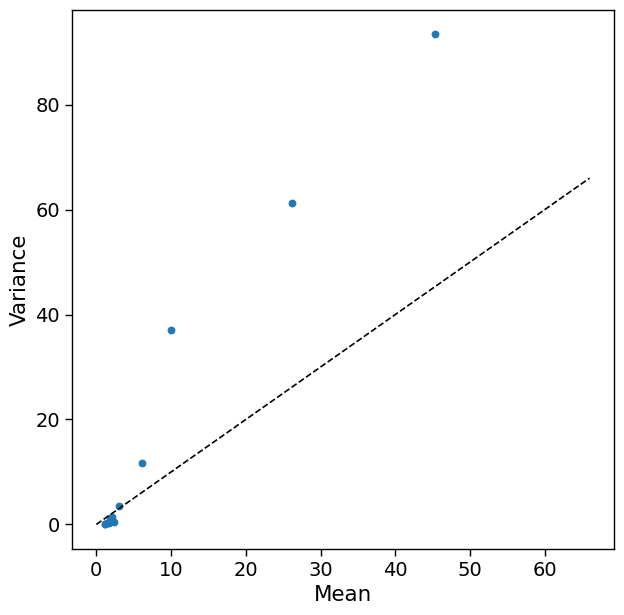

In [54]:
# We also bin the dates analysed and plot the mean counts vs their variance in each bin
xx = xai["DeltaMonth"].values
yy = xai["Count"].values

xai2 = xai.copy()
xai2["bin"] = pd.cut(xx, bins=12, labels=False)
xai2


fig, ax = plt.subplots(figsize=(7, 7))

var_data = xai2[["bin", "Count"]].groupby("bin").var()["Count"]
mean_data = xai2[["bin", "Count"]].groupby("bin").mean()["Count"]

ax.scatter(mean_data, var_data)

ax.set_ylabel("Variance")
ax.set_xlabel("Mean")

ax.plot([0, xai["Count"].max()], [0, xai["Count"].max()], color="black", linestyle="dashed")
plt.show()

## Negative Binomial Regression

Since the data shows clear signs of overdispersion, we adopt a Negative Binomial model to replace the Poisson Regression.
We specifically adopt the NB1 form of the Negative Binomial. ([See statmodels documentation](https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.NegativeBinomial.html))

In [55]:
METHOD = "nb1"

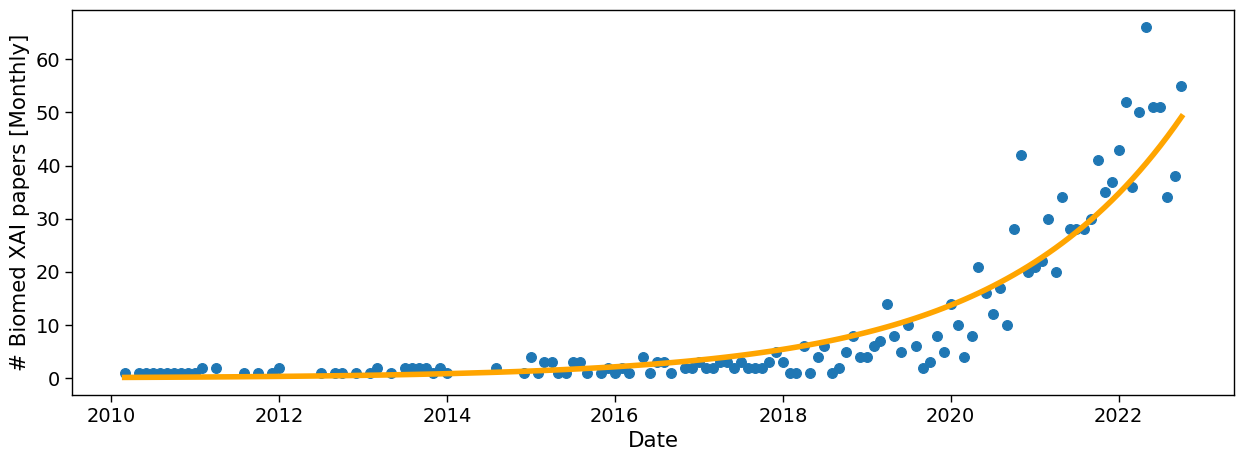

In [68]:
XX = xai[["DeltaMonth"]]
XX = sm.add_constant(XX)

yy = xai["Count"].values

clf = NegativeBinomial(yy, XX, loglike_method=METHOD, missing='drop')
fitted_model = clf.fit(disp=0)

y_hat = fitted_model.predict(XX)

residuals = yy-y_hat
sse_single_fit = np.dot(residuals, residuals)

r2_single_fit = r2_score(yy, y_hat)

fig, ax = plt.subplots(figsize=(15,5))

ax.scatter(xai["date"], yy, s=50)
ax.set_ylabel("# Biomed XAI papers [Monthly]")
ax.set_xlabel("Date")
ax.plot(xai["date"], y_hat, color="orange", linewidth=4)

plt.show()


In [69]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:                      y   No. Observations:                  123
Model:               NegativeBinomial   Df Residuals:                      121
Method:                           MLE   Df Model:                            1
Date:                Wed, 01 Mar 2023   Pseudo R-squ.:                  0.2175
Time:                        10:25:56   Log-Likelihood:                -321.02
converged:                       True   LL-Null:                       -410.24
Covariance Type:            nonrobust   LLR p-value:                 1.063e-40
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9484      0.229     -8.498      0.000      -2.398      -1.499
DeltaMonth     0.0387      0.002     21.758      0.000       0.035       0.042
alpha          0.5076      0.217      2.342      0.019       0.083       0.932
==============================================================================
"""

# Piecewise exponential fit

Fit the trend data using a piecewise exponential function. We model the piecewise exponential using the same Negative Binomial Regression,
and including a binary threshold indicator (i.e. a Heaviside step function) to alter the parameters after a change in trend.

## Find the best splitting point

In [70]:
xx = xai["DeltaMonth"].values
yy = xai["Count"].values

squared_errors = []
popt_data = []



# We limit the possible split points to include sufficient data points in both sequences
# We start looking from the 10th data point to the 107th (i.e. 15-to-last) point.
sstart = 10
send = 15

for j in range(sstart, len(xai)-send):
    
    split_XX = xai[["DeltaMonth"]].copy() 
    split_XX["threshold"] = np.concatenate([np.zeros(j), np.ones(len(xx)- j)])
    split_XX = sm.add_constant(split_XX)

    
    clf = NegativeBinomial(yy, split_XX, loglike_method=METHOD, missing='drop')
    fitted_model = clf.fit(disp=0)


    y_hat_pw = fitted_model.predict(split_XX)

    r2 = r2_score(yy, y_hat_pw) 

    residuals = yy - y_hat_pw
    sse = np.dot(residuals, residuals)
    squared_errors.append(sse)
    date = xai["date"].iloc[j]
    
    popt_data.append([j, sse, date, r2] )#+ [clf.intercept_] + clf.coef_.tolist())
    

popt_data = pd.DataFrame(popt_data)
popt_data.columns = ["j", "SSE", "date", "R2"]# + ["piecewise_popt_{}".format(c) for c in ["a", "b", "c"]]
popt_data

,j,SSE,date,R2
0,10,2995.984633,2011-02-01,0.889048
1,11,2958.640479,2011-04-01,0.890431
2,12,2924.457140,2011-08-01,0.891697
3,13,2911.562019,2011-10-01,0.892175
4,14,2899.971020,2011-12-01,0.892604
...,...,...,...,...
93,103,3183.950053,2021-03-01,0.882087
94,104,3313.355342,2021-04-01,0.877295
95,105,3187.881915,2021-05-01,0.881942
96,106,3354.737753,2021-06-01,0.875763


In [71]:
# Show the best change point to start the second sequence

best_split = popt_data.iloc[np.argmin(popt_data["SSE"].values)]
j = best_split["j"]
# j = 80
# best_split = popt_data.iloc[80]
piecewise_popt = best_split.values[4:]
split_XX = np.vstack([xx, np.concatenate([np.zeros(j), np.ones(len(xx)- j)])]).T
split_XX = sm.add_constant(split_XX)


clf = NegativeBinomial(yy, split_XX, loglike_method=METHOD, missing='drop')
fitted_model = clf.fit(disp=0)


y_hat_pw = fitted_model.predict(split_XX)


y_hat_split = fitted_model.predict(split_XX)

print("Best splitting point at ", best_split.date)

Best splitting point at  2020-10-01 00:00:00


In [72]:
# Fix the trend change using the best split
xai["threshold"] = (xai["date"]>=best_split.date).astype(int)
xai

,Month,Year,Count,date,DeltaMonth,threshold
0,3,2010,1,2010-03-01,0.000000,0
1,5,2010,1,2010-05-01,2.004148,0
2,6,2010,1,2010-06-01,3.022649,0
3,7,2010,1,2010-07-01,4.008296,0
4,8,2010,1,2010-08-01,5.026797,0
...,...,...,...,...,...,...
118,6,2022,51,2022-06-01,147.025606,1
119,7,2022,51,2022-07-01,148.011253,1
120,8,2022,34,2022-08-01,149.029754,1
121,9,2022,38,2022-09-01,150.048256,1


## Evaluate average parameters using bootstrapping

In [112]:
# Calculate parameters for fit using bootstrapping
num_bootstrap = 1000

# Calculate the 95% confidence interval factor derived from a t-distribution
conf_int_factor = stats.t.isf(0.025, num_bootstrap-1)

piecewise_params = []
counter = 0

np.random.seed(42)

pbar = tqdm(total=num_bootstrap)
while counter<num_bootstrap:
    df_tmp = xai.sample(frac=1, replace=True)
    
    yy_tmp = df_tmp["Count"]
    pw_fit_XX = df_tmp[["DeltaMonth", "threshold"]].copy() 
    pw_fit_XX = sm.add_constant(pw_fit_XX)
 
    clf = NegativeBinomial(yy_tmp, pw_fit_XX, loglike_method=METHOD, missing='drop')
    # Filter the warnings produced by numpy for some iterations of bootstrapping
    with np.errstate(divide='ignore'):
        fitted_model = clf.fit(disp=0)

    piecewise_params.append(fitted_model.params)
    counter += 1
    pbar.update(1)
        
piecewise_params = pd.DataFrame(np.vstack(piecewise_params))
piecewise_params.columns = ["const", "DeltaMonth", "threshold", "alpha"]


params_means = piecewise_params.mean()
params_means_ci = conf_int_factor * piecewise_params.std()/np.sqrt(num_bootstrap)

print("Parameter means:\n", params_means, sep="")

  0%|          | 0/1000 [00:00<?, ?it/s]

Parameter means:
const        -0.810955
DeltaMonth    0.024486
threshold     0.994573
alpha         0.150303
dtype: float64


In [93]:
params_means["const"]

-0.7950481441492223

In [95]:
params_means_ci["const"]

0.013114030190375945

## Calculate F-statistic to compare the single exponential fit vs the piecewise exponential

In [26]:
def calc_F_statistic(sse1, sse2, df1, df2):
    fstat = ((sse1-sse2)/(df1-df2)) / (sse2/df2)
    pval = stats.f.sf(fstat, df1, df2)
    return (fstat, pval)

# Number of degrees of freedom of the two models
dof1 = len(xai)-3
dof2 = len(xai)-4

fstat, pvalue = calc_F_statistic(sse_single_fit, best_split.SSE, dof1, dof2)

print(f"F-statistic: {fstat}  -  corresponding p-value: {pvalue}")

F-statistic: 40.939776383726446  -  corresponding p-value: 1.4980067907926295e-63


## Plot the piecewise exponential fit

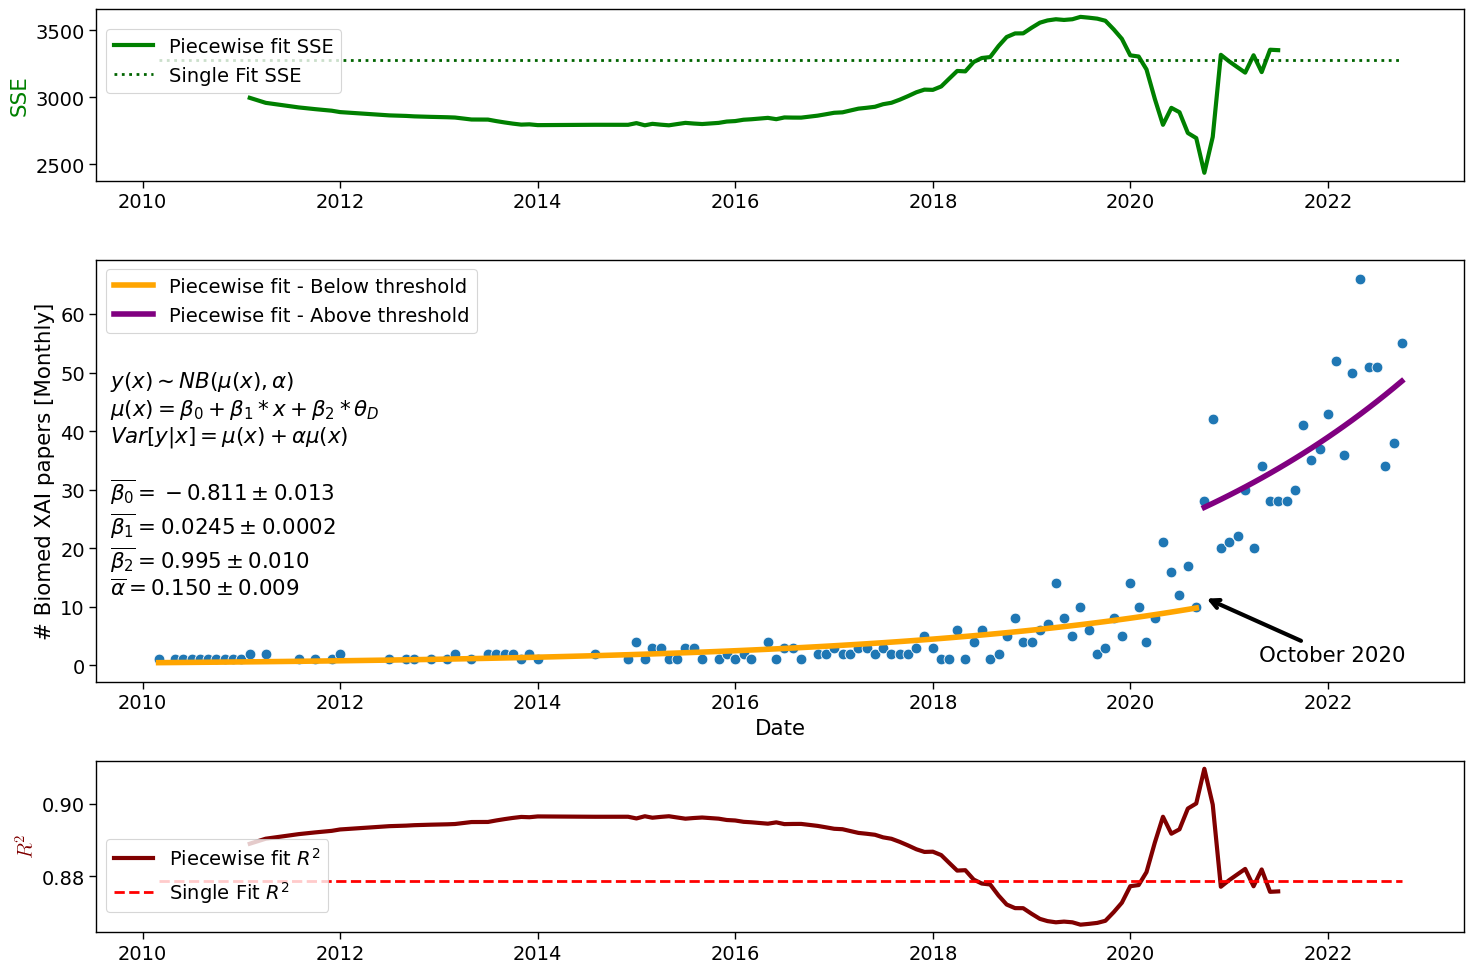

In [118]:
fig = plt.figure(figsize=(15,10))

gs = gridspec.GridSpec(4, 1)

ax = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[1:3,0])
ax3 = plt.subplot(gs[3,0])




ax.plot(xai['date'].iloc[sstart:-send], squared_errors, color="green", label="Piecewise fit SSE", linewidth=3)
ax.hlines(sse_single_fit, xai["date"].iloc[0], xai["date"].iloc[-1], linestyle="dotted", color="darkgreen", label="Single Fit SSE", linewidth=2)
ax.set_ylabel("SSE")
ax.legend(bbox_to_anchor=(0.0, 0.94), loc='upper left')

ax3.set_ylabel(r"$R^2$", usetex=True)
ax3.plot(xai["date"].iloc[sstart:-send], popt_data["R2"], color="maroon", label=r"Piecewise fit $R^2$", linewidth=3)

ax3.hlines(r2_single_fit, xai["date"].iloc[0], xai["date"].iloc[-1], color="red", linestyle="dashed", label=r"Single Fit $R^2$", linewidth=2)
ax3.legend(bbox_to_anchor=(0.0, 0.06), loc='lower left')


ax.yaxis.label.set_color('green')
ax3.yaxis.label.set_color('maroon')


# ax2.text(0.01, 0.25, r"$y(x) = (a + b* \theta_D) * \mathscr{e}^{(c + d * \theta_D) * x}$" +"\n" +"\n" +
#          "$\overline{a} = %.3f \pm %.3f$" % (params_means.a, params_means_ci.a) +"\n"  +
#          "$\overline{b} = %.3f \pm %.3f$" % (params_means.b, params_means_ci.b) +"\n"  +
#          "$\overline{c} = %.3f \pm %.3f$" % (params_means.c, params_means_ci.c) +"\n"  +
#          "$\overline{d} = %.3f \pm %.3f$" % (params_means.d, params_means_ci.d), transform=ax2.transAxes)


ax2.text(0.01, 0.15, r"$y(x) \sim NB(\mu(x), \alpha)$"  + "\n" +
         r"$\mu(x) = \beta_0 + \beta_1 * x + \beta_2 * \theta_D$" + "\n" +
         r"$Var[y|x] = \mu(x) + \alpha \mu(x)$" 
         +"\n" +"\n" +
         r"$\overline{\beta_0} = %.3f \pm %.3f$" % (params_means["const"], params_means_ci["const"]) +"\n"  +
         r"$\overline{\beta_1} = %.4f \pm %.4f$" % (params_means["DeltaMonth"], params_means_ci["DeltaMonth"]) +"\n"  +
         r"$\overline{\beta_2} = %.3f \pm %.3f$" % (params_means["threshold"], params_means_ci["threshold"]) +"\n"  +
         r"$\overline{\alpha} = %.3f \pm %.3f$" % (params_means["alpha"], params_means_ci["alpha"]) +"\n"  
         , transform=ax2.transAxes)




# Bottom plot, best piecewise exponential fit and the corresponding observations
sns.scatterplot(data=xai, x="date", y="Count", ax=ax2, s=60)

# y_hat = piecewise_exp_function(single_fit_XX, *popt)
ax2.plot(xai["date"].iloc[:j], y_hat_split[:j], color="orange", linewidth=4, label="Piecewise fit - Below threshold")
ax2.plot(xai["date"].iloc[j:], y_hat_split[j:], color="purple", linewidth=4, label="Piecewise fit - Above threshold")
ax2.set_ylabel("# Biomed XAI papers [Monthly]")
ax2.set_xlabel("Date")
ax2.legend()


ax2.annotate("October 2020", xy=(0.81, 0.2), xytext=(0.85, 0.05), xycoords="axes fraction", textcoords="axes fraction", 
            arrowprops={"arrowstyle":"->", "color":"black", "lw": 3})

plt.subplots_adjust(hspace=0.6)
fig.tight_layout()
plt.show()
fig.savefig("plots/xai_trend_changepoint_split__NBinom.pdf", bbox_inches="tight")
plt.close(fig)

# Timeshift fit

Fit a single exponential function where the change in trend is modelled as a shift forward in time.

In [103]:
# Copy the previous dataframe and add a variable that is the difference in months centered on the optimal changepoint, october 2020
ts_df = xai.copy()
ts_df["CenteredDeltaMonth"] = ts_df["DeltaMonth"] - ts_df[ts_df["date"]==best_split.date]["DeltaMonth"].iloc[0]
ts_df = ts_df.assign(threshold=(ts_df["CenteredDeltaMonth"] >= 0).astype(int))
ts_df

,Month,Year,Count,date,DeltaMonth,threshold,CenteredDeltaMonth
0,3,2010,1,2010-03-01,0.000000,0,-127.049837
1,5,2010,1,2010-05-01,2.004148,0,-125.045689
2,6,2010,1,2010-06-01,3.022649,0,-124.027187
3,7,2010,1,2010-07-01,4.008296,0,-123.041541
4,8,2010,1,2010-08-01,5.026797,0,-122.023039
...,...,...,...,...,...,...,...
118,6,2022,51,2022-06-01,147.025606,1,19.975770
119,7,2022,51,2022-07-01,148.011253,1,20.961416
120,8,2022,34,2022-08-01,149.029754,1,21.979917
121,9,2022,38,2022-09-01,150.048256,1,22.998419


In [107]:
# Bootstrap to estimate the timeshift and its 95% confidence interval

np.random.seed(42)

delta_months = []
ts_R2 = []
ts_SSE = []
for num_iter in tqdm(range(num_bootstrap)):
    df2 = ts_df.sample(frac=1, replace=True)
    XX2 = df2[["CenteredDeltaMonth", "threshold"]].values
    yy2 = df2["Count"].values
    

    
    y_hat2 = None
    
    def timeskip_func(shift):
        global y_hat2
        x = XX2[:,0]
        threshold = XX2[:,1]
        X_adj = (x + shift*threshold).reshape(-1,1)
        X_adj = sm.add_constant(X_adj)
        clf = NegativeBinomial(yy2, X_adj, loglike_method=METHOD, missing='drop')
        fitted_model = clf.fit(disp=0)

        y_hat2 = fitted_model.predict(X_adj)
        
        residuals = yy2-y_hat2
        return np.dot(residuals, residuals)
    
    # Filter the warnings produced by numpy for some iterations of bootstrapping
    with np.errstate(divide='ignore'):
        shift = minimize_scalar(timeskip_func)
    # except RuntimeWarning:
    #     break
    residuals = yy2-y_hat2
    ts_R2.append(r2_score(yy2, y_hat2))
    ts_SSE.append(np.dot(residuals, residuals))

    if shift.success:
        delta_months.append(shift.x)
    
d_mean = np.mean(delta_months)
d_std_err = np.std(delta_months)/np.sqrt(num_bootstrap)


r2_mean = np.mean(ts_R2)
r2_ci = np.std(ts_R2)/np.sqrt(num_bootstrap-1) * conf_int_factor


sse_mean =  np.mean(ts_SSE)
sse_ci = np.std(ts_SSE)/np.sqrt(num_bootstrap-1) * conf_int_factor



  0%|          | 0/1000 [00:00<?, ?it/s]

In [108]:
print("Average shift: ", d_mean)

Average shift:  25.206117698851834


In [109]:
# Add the adjusted date for plotting purposes (i.e. shift forward the datapoints after the change threshold
ts_df["AdjustedCenteredDeltaMonth"] = ts_df["CenteredDeltaMonth"] + d_mean*ts_df["threshold"]
ts_df["adjusted_date"] = ts_df["date"]+ dt.timedelta(days=d_mean*30)*ts_df["threshold"].astype(int)
ts_df

,Month,Year,Count,date,DeltaMonth,threshold,CenteredDeltaMonth,AdjustedCenteredDeltaMonth,adjusted_date
0,3,2010,1,2010-03-01,0.000000,0,-127.049837,-127.049837,2010-03-01 00:00:00.000000
1,5,2010,1,2010-05-01,2.004148,0,-125.045689,-125.045689,2010-05-01 00:00:00.000000
2,6,2010,1,2010-06-01,3.022649,0,-124.027187,-124.027187,2010-06-01 00:00:00.000000
3,7,2010,1,2010-07-01,4.008296,0,-123.041541,-123.041541,2010-07-01 00:00:00.000000
4,8,2010,1,2010-08-01,5.026797,0,-122.023039,-122.023039,2010-08-01 00:00:00.000000
...,...,...,...,...,...,...,...,...,...
118,6,2022,51,2022-06-01,147.025606,1,19.975770,45.181887,2024-06-26 04:24:17.075424
119,7,2022,51,2022-07-01,148.011253,1,20.961416,46.167534,2024-07-26 04:24:17.075424
120,8,2022,34,2022-08-01,149.029754,1,21.979917,47.186035,2024-08-26 04:24:17.075424
121,9,2022,38,2022-09-01,150.048256,1,22.998419,48.204537,2024-09-26 04:24:17.075424


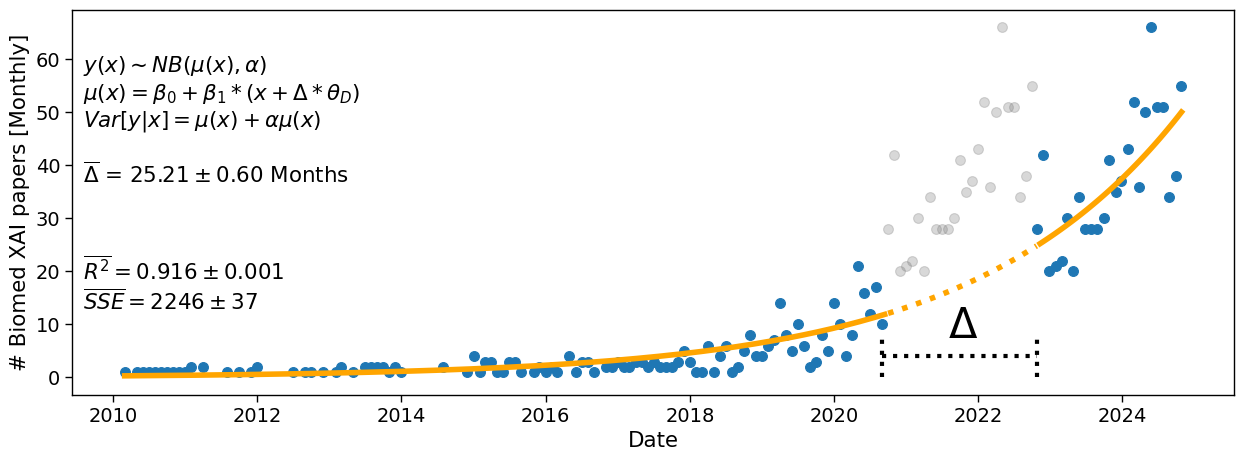

In [119]:
fig, ax = plt.subplots(figsize=(15,5))

# XX = ts_df[["CenteredDeltaMonth", "threshold"]].values
XX = ts_df[["AdjustedCenteredDeltaMonth"]]
XX = sm.add_constant(XX)
yy = ts_df["Count"].values

clf = NegativeBinomial(yy, XX, loglike_method=METHOD, missing='drop')
fitted_model = clf.fit(disp=0)#, start_params=[-0.81598716,  0.02543825 ,  0.12862527])
    
    
n_adj_points = ts_df["threshold"].sum()

adj_date = pd.date_range(start=ts_df["adjusted_date"].iloc[0],
                  end=ts_df["adjusted_date"].iloc[-1],
                  periods=300)



ax.scatter(ts_df[ts_df["threshold"]==1]["date"], yy[-n_adj_points:], color="gray", s=50, alpha=0.3)

ax.scatter(ts_df["adjusted_date"], yy, s=50)


XX_plot_1 = np.linspace(ts_df["AdjustedCenteredDeltaMonth"].iloc[0], ts_df["AdjustedCenteredDeltaMonth"].iloc[-1], 300).reshape(-1,1)
XX_plot_1 = sm.add_constant(XX_plot_1)

y_hat_plot1 = fitted_model.predict(XX_plot_1)



adj_df = ts_df[ts_df["date"]!=ts_df["adjusted_date"]]

ix1 = np.where(adj_date<adj_df["date"].iloc[0])[0]
ax.plot(adj_date[ix1], y_hat_plot1[ix1], color="orange", linewidth=4)

ix2 = np.where((adj_date>=adj_df["date"].iloc[0])&(adj_date<adj_df["adjusted_date"].iloc[0]))[0]
ax.plot(adj_date[ix2], y_hat_plot1[ix2], color="orange", linewidth=4, linestyle="dotted")

ix3 = np.where(adj_date>=adj_df["adjusted_date"].iloc[0])[0]
ax.plot(adj_date[ix3], y_hat_plot1[ix3], color="orange", linewidth=4)



b1 = ts_df[ts_df["threshold"]==0]["adjusted_date"].iloc[-1]
b2 = ts_df[ts_df["threshold"]==1]["adjusted_date"].iloc[0]
ax.vlines(b1, 0, 8, color="black", linewidth=3, linestyle="dotted")
ax.vlines(b2, 0, 8, color="black", linewidth=3, linestyle="dotted")
ax.hlines(4, b1, b2, color="black", linewidth=3, linestyle="dotted")
ax.text(0.754, 0.147, r"$ \Delta$", transform=ax.transAxes, fontsize=30)


ax.text(0.01, 0.55, r"$y(x) \sim NB(\mu(x), \alpha)$"  + "\n" +
         r"$\mu(x) = \beta_0 + \beta_1 * (x + \Delta * \theta_D)$" + "\n" +
         r"$Var[y|x] = \mu(x) + \alpha \mu(x)$" 
         +"\n" +"\n" +
        r"$ \overline{\Delta}$" + r" = ${:.2f} \pm {:.2f}$ Months".format(d_mean, conf_int_factor*d_std_err), 
        transform=ax.transAxes)

ax.text(0.01, 0.3, r"$\overline{R^2}$" + "$ = {:.3f} \pm {:.3f}$".format(r2_mean, r2_ci), transform=ax.transAxes)
ax.text(0.01, 0.22, r"$\overline{SSE}$" + "$ = {:.0f} \pm {:.0f}$".format(sse_mean, sse_ci), transform=ax.transAxes)


ax.set_ylabel("# Biomed XAI papers [Monthly]")
ax.set_xlabel("Date")


fig.savefig("plots/timeskip_changepoint_NBinom.pdf", bbox_inches="tight")

# ax.set_yscale("log")
plt.show()